RF - Bayesian Optimization

https://medium.com/datadriveninvestor/alternative-hyperparameter-optimization-techniques-you-need-to-know-part-2-e9b0d4d080a9

https://github.com/ageek/kaggle/blob/master/2016-Kaggle/bnp-paribas-cardif-claims-management/bayesian-optimization-of-random-forest.py

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Import data & library

In [3]:
train_mca = pd.read_csv("/content/drive/My Drive/최종데이터/train_mca_jo_sum.csv")
test_mca = pd.read_csv("/content/drive/My Drive/최종데이터/test_mca_jo_sum.csv")

train_rf = pd.read_csv("/content/drive/My Drive/최종데이터/train_rf_jo_sum_final.csv")
test_rf = pd.read_csv("/content/drive/My Drive/최종데이터/test_rf_jo_sum.csv")

train_nonanswer = pd.read_csv("/content/drive/My Drive/최종데이터/train_nonanswer_jo_sum_final.csv")
test_nonanswer = pd.read_csv("/content/drive/My Drive/최종데이터/test_nonanswer_jo_sum.csv")

train_mean = pd.read_csv("/content/drive/My Drive/최종데이터/train_mean_jo_sum_final.csv")
test_mean = pd.read_csv("/content/drive/My Drive/최종데이터/test_mean_jo_sum.csv")

train_na = pd.read_csv("/content/drive/My Drive/최종데이터/train_na_jo_sum_final.csv")
test_na = pd.read_csv("/content/drive/My Drive/최종데이터/test_na_jo_sum.csv")

In [17]:
yte = pd.read_csv("/content/drive/My Drive/최종데이터/sampleSubmission2016.csv")
yte.head()

,USER_ID,Predictions
0,2,Democrat
1,3,Republican
2,6,Republican
3,7,Democrat
4,14,Democrat


In [4]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score

In [5]:
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-vq0d0sfa
  Running command git clone -q https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-vq0d0sfa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/15/c4/1310a054d33abc318426a956e7d6df0df76a6ddfa9c66f6310274fb75d42/pyaml-20.4.0-py2.py3-none-any.whl
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.dev0-cp36-none-any.whl size=102002 sha256=5d1b9d56c56abf5110cf7d9e50e2975e16f3043d2a37dae6047ae4700f0945e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-mg10qt1y/wheels/11/6f/86/2b772172db85ad0b4487d67e325e535ee8e7782b2a1dfcadf5
Successfully built scikit-optimize


In [6]:
# Importing core libraries
import pprint
import joblib

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Skopt functions
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from sklearn.metrics import make_scorer

2. Split data & Encoding

In [8]:
train_mca.head()

,USER_ID,Gender,Income,HouseholdStatus,EducationLevel,Party,age,marriage,kids,env_Q_p_fight.ifoU,mo_Q_minwage_job,mo_Q_fulltimejob,Life_Q_collectHobby,mo_Q_has_enoughcash_now,edu_Q_publicschool,re_Q_jealous,Life_Q_drink,re_Q_newromance,env_Q_Sesame_str,ex_Q_stress_event,edU_Q_mas_doc_degree,env_Q_p_married,ps_Q_Science_Art,ps_Q_Study_Try,ps_Q_WeatherMood,re_Q_successfulthan_friend,ex_Q_accomplish,Life_Q_readBook,ps_Q_Giving_Receiving,Life_Q_glasses,env_Q_same_state,ps_Q_Idealist,ex_Q_crimethreatened,env_Q_overhead_task,ps_Q_QuickTemper,Life_Q_standardTime,Hel_Q_dailyVitamin,ps_Q_happy_right,ps_Q_Rules,ex_Q_travelabroad,...,re_Q_meetoffline,mo_Q_feel_financialdebt,ps_Q_Normal,ps_Q_Punctuate,ps_Q_LikeFirstName,re_Q_likepeople,Life_Q_ownTool,Life_Q_work50h,ps_Q_GoodLiar,Hel_Q_medicineTake,ps_Q_RetailTherapy,Life_Q_morningAlarm,Life_Q_brushT2,Life_Q_pet,re_Q_carrygrudge,mo_Q_has_debt,Life_Q_breakfast,ps_Q_Adventurous,mo_Q_own_residence,ps_Q_Optimist,re_Q_Dad_householdpower,ex_Q_treehouse,ps_Q_Overweight,ex_Q_cry60D,ps_Q_BetterAfter5y,ps_Q_Checklist,Life_Q_watchTV,Life_Q_livealone,ps_Q_LeftHanded,env_Q_p_spank,ps_Q_LifePurpose,Life_Q_exerc3we,re_Q_havesibling,ps_Q_Creative,edu_Q_goodat_math,careness,fairness,loyalty,authority,sanctity
0,1,Male,0.00,Married (w/kids),0,Democrat,70s,Married,w/kids,No,No,No,No,Yes,Yes,No,Yes,No,No,No,No,Yes,No,No,No,No,No,Yes,No,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,...,Yes,No,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,No,Yes,No,No,No,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,No,No,Yes,No,No,No,No,Yes,3,6,4,11,1
1,4,Female,1.00,Domestic Partners (w/kids),2,Democrat,40s,Domestic Partners,w/kids,Yes,No,No,No,Yes,Yes,No,Yes,No,Yes,No,No,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,Yes,...,Yes,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,No,No,Yes,No,Yes,No,Yes,No,Yes,No,Yes,No,No,No,No,No,No,Yes,No,1,4,0,12,1
2,5,Male,0.74,Single (no kids),1,Republican,10s,Single,no kids,Yes,Yes,No,No,Yes,No,No,No,No,Yes,No,No,Yes,Yes,Yes,No,Yes,No,Yes,No,No,Yes,No,No,Yes,No,No,No,No,Yes,No,...,Yes,No,No,Yes,Yes,No,Yes,No,No,No,No,No,No,Yes,No,No,Yes,No,Yes,No,No,No,No,No,No,No,Yes,No,No,No,Yes,No,Yes,No,No,1,2,3,15,1
3,8,Male,0.88,Married (w/kids),2,Democrat,30s,Married,w/kids,Yes,No,Yes,No,No,Yes,No,Yes,No,Yes,No,No,Yes,Yes,No,No,Yes,Yes,No,Yes,Yes,No,Yes,No,No,No,Yes,No,Yes,Yes,Yes,...,No,No,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Yes,No,No,No,Yes,Yes,Yes,Yes,No,No,No,No,Yes,Yes,No,No,No,Yes,Yes,No,Yes,No,Yes,2,7,4,12,2
4,9,Female,0.61,Married (w/kids),1,Republican,30s,Married,w/kids,Yes,No,No,No,Yes,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,Yes,No,No,No,Yes,No,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,...,No,No,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,No,Yes,No,No,Yes,Yes,No,No,Yes,Yes,Yes,No,Yes,No,No,Yes,No,No,Yes,No,Yes,1,3,2,8,1


In [9]:
mca_xtr = train_mca.drop(['Party','USER_ID'],axis = 1)
mca_ytr = train_mca['Party']

rf_xtr = train_rf.drop(['Party','USER_ID'],axis = 1)
rf_ytr = train_rf['Party']

nonanswer_xtr = train_nonanswer.drop(['Party','USER_ID'],axis = 1)
nonanswer_ytr = train_nonanswer['Party']

mean_xtr = train_mean.drop(['Party','USER_ID'],axis = 1)
mean_ytr = train_mean['Party']

na_xtr = train_na.drop(['Party','USER_ID'],axis = 1)
na_ytr = train_na['Party']

In [10]:
mca_xtr_dummy = pd.get_dummies(mca_xtr)
rf_xtr_dummy = pd.get_dummies(rf_xtr)
nonanswer_xtr_dummy = pd.get_dummies(nonanswer_xtr)
mean_xtr_dummy = pd.get_dummies(mean_xtr)
na_xtr_dummy = pd.get_dummies(na_xtr)

In [18]:
mca_xte = test_mca.drop(['USER_ID'],axis = 1)
rf_xte = test_rf.drop(['USER_ID'],axis = 1)
nonanswer_xte = test_nonanswer.drop(['USER_ID'],axis = 1)
mean_xte = test_mean.drop(['USER_ID'],axis = 1)
na_xte = test_na.drop(['USER_ID'],axis = 1)

In [19]:
mca_xte_dummy = pd.get_dummies(mca_xte)
rf_xte_dummy = pd.get_dummies(rf_xte)
nonanswer_xte_dummy = pd.get_dummies(nonanswer_xte)
mean_xte_dummy = pd.get_dummies(mean_xte)
na_xte_dummy = pd.get_dummies(na_xte)

4. (전체 데이터) Random Forest + Bayesian Optimization

1시간째 돌아가서... subset selection 안녕...

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [ ]:
sfs1 = sfs(
  RFC(n_jobs = -1,random_state = 42), k_features = 15,scoring = 'accuracy',cv = 3,n_jobs = -1
)

In [ ]:
sfs_mca = sfs1.fit(mca_xtr_dummy,mca_ytr)
mca_cols = list(sfs_mca.k_feature_idx_)


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [ ]:
sfs_rf = sfs1.fit(rf_xtr_dummy,rf_ytr)
rf_cols = list(sfs_rf.k_feature_idx_)

In [ ]:
sfs_nonanswer = sfs1.fit(nonanswer_xtr_dummy,nonanswer_ytr)
nonanswer_cols = list(sfs_nonanswer.k_feature_idx_)

In [ ]:
sfs_mean = sfs1.fit(mean_xtr_dummy,mean_ytr)
mean_cols = list(sfs_mean.k_feature_idx_)

In [ ]:
mca_cols = list(sfs_mca.k_feature_idx_)

rf_mca.fit(mca_xtr_dummy[:,mca_cols],mca_ytr)
mca_pred = rf_mca.predict(mca_xte_dummy[:,mca_cols])
print('예측 정확도: {0:.4f}'.format(accuracy_score(yte,mca_pred)))

**Bayesian Optimization**

In [11]:
params = {
    'n_estimators':[100,200,300,400,500],
    'max_depth':Integer(2,20),
    'criterion':['gini','entropy'],
    'max_features':['log2','sqrt'],
    'min_samples_split':Integer(2,20),
    'min_samples_leaf':Integer(1,10)
}

In [15]:
rf_bayes_cv = BayesSearchCV(
    estimator = RFC(),
    search_spaces = params,
    scoring = 'accuracy',
    cv = StratifiedKFold(
        n_splits = 5,
        shuffle = False,
        random_state = 42
    ),
    n_iter = 10,
    n_jobs = 1,
    return_train_score = False,
    refit = True,
    optimizer_kwargs = {'base_estimator':'GP'},
    random_state = 22

)

In [13]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(rf_bayes_cv.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(rf_bayes_cv.best_params_)
    print('Model #{}\nBest accuracy: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(rf_bayes_cv.best_score_, 6),
        rf_bayes_cv.best_params_
    ))

In [16]:
result_mca = rf_bayes_cv.fit(mca_xtr_dummy,mca_ytr,callback = status_print)

Model #1
Best accuracy: 0.618892
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 13), ('max_features', 'sqrt'), ('min_samples_leaf', 3), ('min_samples_split', 4), ('n_estimators', 200)])

Model #2
Best accuracy: 0.62524
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('min_samples_leaf', 7), ('min_samples_split', 19), ('n_estimators', 200)])

Model #3
Best accuracy: 0.62524
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('min_samples_leaf', 7), ('min_samples_split', 19), ('n_estimators', 200)])

Model #4
Best accuracy: 0.62524
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('min_samples_leaf', 7), ('min_samples_split', 19), ('n_estimators', 200)])

Model #5
Best accuracy: 0.62524
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('min_samples_leaf', 7), ('min_samples_split', 19),

In [ ]:
result_rf = rf_bayes_cv.fit(rf_xtr_dummy,rf_ytr,callback = status_print)

Model #1
Best accuracy: 0.617545
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 13), ('max_features', 'sqrt'), ('n_estimators', 200)])

Model #2
Best accuracy: 0.628511
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])

Model #3
Best accuracy: 0.628511
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])

Model #4
Best accuracy: 0.628511
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])

Model #5
Best accuracy: 0.628511
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])

Model #6
Best accuracy: 0.628896
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 9), ('max_features', 'log2'), ('n_estimators', 300)])

Model #7
Best accuracy: 0.628896
Best params: OrderedDict([('criterion', 'e

In [ ]:
result_nonanswer = rf_bayes_cv.fit(nonanswer_xtr_dummy,nonanswer_ytr,callback = status_print)

Model #1
Best accuracy: 0.62601
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 13), ('max_features', 'sqrt'), ('min_samples_leaf', 3), ('min_samples_split', 4), ('n_estimators', 200)])

Model #2
Best accuracy: 0.633513
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('min_samples_leaf', 7), ('min_samples_split', 19), ('n_estimators', 200)])

Model #3
Best accuracy: 0.633513
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('min_samples_leaf', 7), ('min_samples_split', 19), ('n_estimators', 200)])

Model #4
Best accuracy: 0.633513
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('min_samples_leaf', 7), ('min_samples_split', 19), ('n_estimators', 200)])

Model #5
Best accuracy: 0.633513
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('min_samples_leaf', 7), ('min_samples_split', 1

In [ ]:
result_mean = rf_bayes_cv.fit(mean_xtr_dummy,mean_ytr,callback = status_print)

Model #1
Best accuracy: 0.618507
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 13), ('max_features', 'sqrt'), ('n_estimators', 200)])

Model #2
Best accuracy: 0.622932
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])

Model #3
Best accuracy: 0.622932
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])

Model #4
Best accuracy: 0.622932
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])

Model #5
Best accuracy: 0.622932
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])

Model #6
Best accuracy: 0.624086
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 9), ('max_features', 'log2'), ('n_estimators', 300)])

Model #7
Best accuracy: 0.624086
Best params: OrderedDict([('criterion', 'e

In [ ]:
result_na = rf_bayes_cv.fit(na_xtr_dummy,na_ytr,callback = status_print)

Model #1
Best accuracy: 0.608311
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 13), ('max_features', 'sqrt'), ('n_estimators', 200)])

Model #2
Best accuracy: 0.622355
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])

Model #3
Best accuracy: 0.622355
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])

Model #4
Best accuracy: 0.622355
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])

Model #5
Best accuracy: 0.622355
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])

Model #6
Best accuracy: 0.622355
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])

Model #7
Best accuracy: 0.622355
Best params: OrderedDict([('criterion', 'e

Nonanswer 가 제일 낫더라..

*4*. Bayesian Optimization으로 튜닝한 파라미터에 대해 Training Accuracy 계산

**MCA**

In [20]:
# mca Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])
rf_mca = RFC(
    n_estimators = 400, max_depth = 6, criterion = 'entropy', max_features = 'sqrt'
)
rf_mca.fit(mca_xtr_dummy,mca_ytr)
mca_pred = rf_mca.predict(mca_xtr_dummy)
print('예측 정확도: {0:.4f}'.format(accuracy_score(mca_ytr,mca_pred)))

mca_importance = list(sorted(zip(map(lambda x: round(x, 4), rf_mca.feature_importances_), mca_xtr_dummy.columns), 
             reverse=True))

예측 정확도: 0.6899


**RF**

In [90]:
# rf Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 9), ('max_features', 'log2'), ('n_estimators', 300)])
rf_rf = RFC(
    n_estimators = 300, max_depth = 9, criterion = 'entropy', max_features = 'log2'
)
rf_rf.fit(rf_xtr_dummy,rf_ytr)
rf_pred = rf_rf.predict(rf_xtr_dummy)
print('예측 정확도: {0:.4f}'.format(accuracy_score(rf_ytr,rf_pred)))

rf_importance = list(sorted(zip(map(lambda x: round(x, 4), rf_rf.feature_importances_), rf_xtr_dummy.columns), 
             reverse=True))

예측 정확도: 0.9140


**Nonanswer**

In [22]:
# nonanswer Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 5), ('max_features', 'sqrt'), ('n_estimators', 200)])
rf_nonanswer = RFC(
    n_estimators = 200, max_depth = 5, criterion = 'entropy', max_features = 'sqrt'
)
rf_nonanswer.fit(nonanswer_xtr_dummy,nonanswer_ytr)
nonanswer_pred = rf_nonanswer.predict(nonanswer_xtr_dummy)

print('예측 정확도: {0:.4f}'.format(accuracy_score(nonanswer_ytr,nonanswer_pred)))

nonanswer_importance = list(sorted(zip(map(lambda x: round(x, 4), rf_nonanswer.feature_importances_), nonanswer_xtr_dummy.columns), 
           reverse=True))

예측 정확도: 0.6760


In [24]:
top40 = [nonanswer_importance[i][1] for i in range(len(rf_importance)) if i < 40]

rf_nonanswer = RFC(
    n_estimators = 200, max_depth = 5, criterion = 'entropy', max_features = 'sqrt'
)
rf_nonanswer.fit(nonanswer_xtr_dummy[top40],nonanswer_ytr)
nonanswer_pred = rf_nonanswer.predict(nonanswer_xtr_dummy[top40])
print('예측 정확도: {0:.4f}'.format(accuracy_score(nonanswer_ytr,nonanswer_pred)))

예측 정확도: 0.6531


In [25]:
top50 = [nonanswer_importance[i][1] for i in range(len(rf_importance)) if i < 50]

rf_nonanswer = RFC(
    n_estimators = 200, max_depth = 5, criterion = 'entropy', max_features = 'sqrt'
)
rf_nonanswer.fit(nonanswer_xtr_dummy[top50],nonanswer_ytr)
nonanswer_pred = rf_nonanswer.predict(nonanswer_xtr_dummy[top50])
print('예측 정확도: {0:.4f}'.format(accuracy_score(nonanswer_ytr,nonanswer_pred)))

예측 정확도: 0.6578


In [26]:
top60 = [nonanswer_importance[i][1] for i in range(len(rf_importance)) if i < 60]

rf_nonanswer = RFC(
    n_estimators = 200, max_depth = 5, criterion = 'entropy', max_features = 'sqrt'
)
rf_nonanswer.fit(nonanswer_xtr_dummy[top60],nonanswer_ytr)
nonanswer_pred = rf_nonanswer.predict(nonanswer_xtr_dummy[top60])
print('예측 정확도: {0:.4f}'.format(accuracy_score(nonanswer_ytr,nonanswer_pred)))

예측 정확도: 0.6616


테스트셋 accuracy 평가 - 0.63218

In [23]:
# Nonanswer Best params: OrderedDict([('criterion', 'gini'), ('max_depth', 9), ('max_features', 'sqrt'), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 500)])
rf_nonanswer = RFC(
    n_estimators = 500, max_depth = 9, criterion = 'gini', max_features = 'sqrt'
)
rf_nonanswer.fit(nonanswer_xtr_dummy,nonanswer_ytr)
nonanswer_pred = rf_nonanswer.predict(nonanswer_xte_dummy)

yte['Predictions'] = nonanswer_pred

In [ ]:
yte.to_csv("submit.csv")

**MEAN**

In [27]:
# mean Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])
rf_mean = RFC(
    n_estimators = 400, max_depth = 6, criterion = 'entropy', max_features = 'sqrt'
)
rf_mean.fit(mean_xtr_dummy,mean_ytr)
mean_pred = rf_mean.predict(mean_xtr_dummy)
print('예측 정확도: {0:.4f}'.format(accuracy_score(mean_ytr,mean_pred)))

mean_importance = list(sorted(zip(map(lambda x: round(x, 4), rf_mean.feature_importances_), mean_xtr_dummy.columns), 
             reverse=True))

예측 정확도: 0.6841


**NA**

In [28]:
# na Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 'sqrt'), ('n_estimators', 400)])
rf_na = RFC(
    n_estimators = 400, max_depth = 6, criterion = 'entropy', max_features = 'sqrt'
)
rf_na.fit(na_xtr_dummy,na_ytr)
na_pred = rf_na.predict(na_xtr_dummy)
print('예측 정확도: {0:.4f}'.format(accuracy_score(na_ytr,na_pred)))

na_importance = list(sorted(zip(map(lambda x: round(x, 4), rf_na.feature_importances_), na_xtr_dummy.columns), 
             reverse=True))

예측 정확도: 0.7134


**5**. (전체 데이터셋) Random Search & Grid Search

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

- Random Search

In [ ]:
params = {
    'n_estimators':[100,200,300,400,500,600],
    'max_depth':Integer(2,20),
    'criterion':['gini','entropy'],
    'max_features':['log2','sqrt'],
    'min_samples_split':Integer(2,20),
    'min_samples_leaf':Integer(1,10)
}

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
criterion = ['gini','entropy']
max_features = ['log2', 'sqrt']
min_samples_split = [x for x in range(2,20,2)]
min_samples_leaf = [1,2,3,4,5,6,7,8,9,10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'criterion':criterion,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf_random = RandomizedSearchCV(estimator = RFC(), param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(nonanswer_xtr_dummy, nonanswer_ytr)              


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 9,
 'min_samples_split': 14,
 'n_estimators': 1200}

- Grid Search

In [ ]:
# Best params: OrderedDict([('criterion', 'gini'), ('max_depth', 9), ('max_features', 'sqrt'), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 500)])

In [ ]:
param_grid = {
    'n_estimators':[1000,1200,1400],
    'max_depth':[10,20,30],
    'criterion':['gini'],
    'max_features':['sqrt'],
    'min_samples_split':[12,14,16],
    'min_samples_leaf':[8,9,10]
}

In [ ]:
grid_search = GridSearchCV(estimator = RFC(), param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(nonanswer_xtr_dummy, nonanswer_ytr)

grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 25.6min finished


{'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 9,
 'min_samples_split': 16,
 'n_estimators': 1200}

Test Accuracy Result = 0.63505

In [ ]:
# Nonanswer Best params: OrderedDict([('criterion', 'gini'), ('max_depth', 9), ('max_features', 'sqrt'), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 500)])
rf_nonanswer = RFC(
    n_estimators = 1200, max_depth = 30, criterion = 'gini', max_features = 'sqrt',min_samples_leaf = 9,min_samples_split = 16
)
rf_nonanswer.fit(nonanswer_xtr_dummy,nonanswer_ytr)
nonanswer_pred = rf_nonanswer.predict(nonanswer_xte_dummy)

# yte['Predictions'] = nonanswer_pred

In [ ]:
yte.to_csv("rf_grid.csv")

6. Variable Filtering by using RFE

In [30]:
from sklearn.feature_selection import RFE

In [ ]:
rfe = RFE(estimator=RFC(), n_features_to_select=200, verbose=1)
rfe.fit(nonanswer_xtr_dummy, nonanswer_ytr)

Fitting estimator with 278 features.
Fitting estimator with 277 features.
Fitting estimator with 276 features.
Fitting estimator with 275 features.
Fitting estimator with 274 features.
Fitting estimator with 273 features.
Fitting estimator with 272 features.
Fitting estimator with 271 features.
Fitting estimator with 270 features.
Fitting estimator with 269 features.
Fitting estimator with 268 features.
Fitting estimator with 267 features.
Fitting estimator with 266 features.
Fitting estimator with 265 features.
Fitting estimator with 264 features.
Fitting estimator with 263 features.
Fitting estimator with 262 features.
Fitting estimator with 261 features.
Fitting estimator with 260 features.
Fitting estimator with 259 features.
Fitting estimator with 258 features.
Fitting estimator with 257 features.
Fitting estimator with 256 features.
Fitting estimator with 255 features.
Fitting estimator with 254 features.
Fitting estimator with 253 features.
Fitting estimator with 252 features.
F

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=200, step=1, verbose=1)

In [ ]:
mask = rfe.support_
tr_200 = nonanswer_xtr_dummy.loc[:, mask]
te_200 = nonanswer_xte_dummy.loc[:,mask]
print(tr_200.columns)

Index(['Income', 'EducationLevel', 'careness', 'fairness', 'loyalty',
       'authority', 'sanctity', 'Gender_Female', 'Gender_Male',
       'HouseholdStatus_Married (w/kids)',
       ...
       'ps_Q_LifePurpose_No', 'ps_Q_LifePurpose_Yes', 'Life_Q_exerc3we_No',
       'Life_Q_exerc3we_Yes', 'ps_Q_Creative_No', 'ps_Q_Creative_Yes',
       'ps_Q_Creative_non_answer', 'edu_Q_goodat_math_No',
       'edu_Q_goodat_math_Yes', 'edu_Q_goodat_math_non_answer'],
      dtype='object', length=200)


Test Accuracy Result = 0.64511

In [ ]:
# Nonanswer Best params: OrderedDict([('criterion', 'gini'), ('max_depth', 9), ('max_features', 'sqrt'), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 500)])
rf_nonanswer = RFC(
    n_estimators = 1200, max_depth = 30, criterion = 'gini', max_features = 'sqrt',min_samples_leaf = 9,min_samples_split = 16
)
rf_nonanswer.fit(tr_200,nonanswer_ytr)
nonanswer_pred = rf_nonanswer.predict(te_200)
# print('예측 정확도: {0:.4f}'.format(accuracy_score(nonanswer_ytr,nonanswer_pred)))
yte['Predictions'] = nonanswer_pred

In [ ]:
yte.to_csv("rf_200.csv")

7. Variable Selection by using Shapely Value

In [32]:
!pip install shap

     |████████████████████████████████| 327kB 5.7MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463914 sha256=02240c9ddfb782a019ceefd09dcaafb4769832a0721d7665da6f0624be2b02ba
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [33]:
import shap

In [34]:
# Grid Search Result
rf_nonanswer = RFC(
    n_estimators = 1200, max_depth = 30, criterion = 'gini', max_features = 'sqrt',min_samples_leaf = 9,min_samples_split = 16
)
rf_nonanswer.fit(nonanswer_xtr_dummy,nonanswer_ytr)
nonanswer_pred = rf_nonanswer.predict(nonanswer_xte_dummy)

**Shapely Value**

In [35]:
explainer = shap.TreeExplainer(rf_nonanswer)
shap_values = explainer.shap_values(nonanswer_xte_dummy)

In [36]:
shap_values

[array([[ 6.20790878e-04,  3.13167711e-03, -4.45309295e-03, ...,
         -5.90991230e-04,  2.03168759e-04, -1.16675353e-03],
        [ 9.33622743e-04,  7.22149526e-04, -6.20292337e-03, ...,
         -9.82303644e-04,  1.08735946e-04,  1.58947008e-03],
        [ 6.79419413e-04, -1.07634629e-03, -3.22829993e-03, ...,
         -9.06209257e-04,  1.62037828e-04,  8.88565321e-04],
        ...,
        [ 1.17249897e-03,  4.85570570e-03, -6.76976418e-03, ...,
         -8.29397556e-04, -3.00010248e-05, -1.17573153e-03],
        [ 6.30415683e-04, -4.27763602e-03, -6.90075508e-03, ...,
         -5.49892827e-04, -8.85492611e-05, -1.12563762e-03],
        [ 5.19751769e-04, -7.49430802e-03, -7.43834509e-03, ...,
         -5.96122655e-04,  1.55815169e-05, -1.01350481e-03]]),
 array([[-6.20790878e-04, -3.13167711e-03,  4.45309295e-03, ...,
          5.90991230e-04, -2.03168759e-04,  1.16675353e-03],
        [-9.33622743e-04, -7.22149526e-04,  6.20292337e-03, ...,
          9.82303644e-04, -1.08735946e

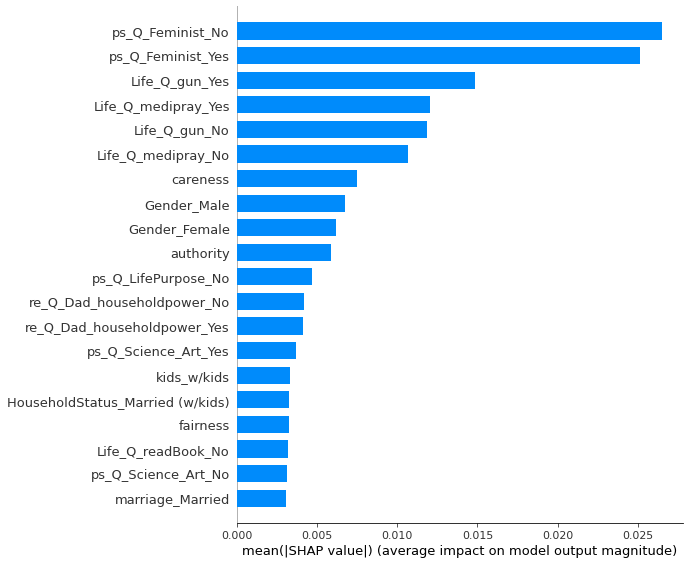

In [37]:
shap.initjs()
shap.summary_plot(shap_values[1],nonanswer_xte_dummy,plot_type = 'bar')

In [38]:
shap_var = ['ps_Q_Feminist','Life_Q_gun','Life_Q_medipray','careness','Gender','authority','ps_Q_LifePurpose',
            're_Q_Dad_householdpower','ps_Q_Science_Art','kids','HouseholdStatus','fairness','Life_Q_readBook','marriage']

Variable Importance

In [39]:
nonanswer_importance = list(sorted(zip(map(lambda x: round(x, 4), rf_nonanswer.feature_importances_), nonanswer_xtr_dummy.columns), 
           reverse=True))
top20 = [nonanswer_importance[i][1] for i in range(len(rf_importance)) if i < 20]
top20

['ps_Q_Feminist_Yes',
 'ps_Q_Feminist_No',
 'Life_Q_gun_Yes',
 'authority',
 'careness',
 'Life_Q_medipray_Yes',
 'fairness',
 'Life_Q_gun_No',
 'Life_Q_medipray_No',
 'EducationLevel',
 'Gender_Male',
 'Gender_Female',
 'loyalty',
 'sanctity',
 'ps_Q_LifePurpose_No',
 're_Q_Dad_householdpower_Yes',
 're_Q_Dad_householdpower_No',
 'ps_Q_Science_Art_Yes',
 'Life_Q_readBook_No',
 'edU_Q_mas_doc_degree_No']

EducationLevel, loyalty, sanctity, edU_Q_mas_doc_degree 추가

RFE

In [40]:
rfe = RFE(estimator=rf_nonanswer, n_features_to_select=20, verbose=1,step = 2)
rfe.fit(nonanswer_xtr_dummy, nonanswer_ytr)

Fitting estimator with 278 features.
Fitting estimator with 276 features.
Fitting estimator with 274 features.
Fitting estimator with 272 features.
Fitting estimator with 270 features.
Fitting estimator with 268 features.
Fitting estimator with 266 features.
Fitting estimator with 264 features.
Fitting estimator with 262 features.
Fitting estimator with 260 features.
Fitting estimator with 258 features.
Fitting estimator with 256 features.
Fitting estimator with 254 features.
Fitting estimator with 252 features.
Fitting estimator with 250 features.
Fitting estimator with 248 features.
Fitting estimator with 246 features.
Fitting estimator with 244 features.
Fitting estimator with 242 features.
Fitting estimator with 240 features.
Fitting estimator with 238 features.
Fitting estimator with 236 features.
Fitting estimator with 234 features.
Fitting estimator with 232 features.
Fitting estimator with 230 features.
Fitting estimator with 228 features.
Fitting estimator with 226 features.
F

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=30, max_features='sqrt',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=9, min_samples_split=16,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=1200, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=20, step=2, verbose=1)

In [41]:
mask = rfe.support_
rfe_tr20 = nonanswer_xtr_dummy.loc[:, mask]
rfe_te20 = nonanswer_xte_dummy.loc[:,mask]
print(rfe_tr20.columns)

Index(['EducationLevel', 'careness', 'fairness', 'loyalty', 'authority',
       'sanctity', 'Gender_Male', 'kids_no kids', 'ps_Q_Science_Art_Yes',
       'Life_Q_readBook_No', 'Life_Q_glasses_Yes', 'Life_Q_gun_No',
       'Life_Q_gun_Yes', 'Life_Q_medipray_No', 'Life_Q_medipray_Yes',
       'Life_Q_MacPC_No', 'ps_Q_Feminist_No', 'ps_Q_Feminist_Yes',
       're_Q_Dad_householdpower_Yes', 'ps_Q_Overweight_Yes'],
      dtype='object')


EducationLevel, loyalty, sanctity, Life_Q_glasses, Life_Q_MacPC, ps_Q_Overweight 추가

In [43]:
selected_xtr = nonanswer_xtr[['ps_Q_Feminist','Life_Q_gun','Life_Q_medipray','careness','Gender','authority','ps_Q_LifePurpose','re_Q_Dad_householdpower',
                             'ps_Q_Science_Art','kids','HouseholdStatus','fairness','Life_Q_readBook','marriage',
                             'EducationLevel','loyalty','sanctity','edU_Q_mas_doc_degree',
                             'Life_Q_glasses','Life_Q_MacPC','ps_Q_Overweight']]

In [44]:
selected_xtr_dummy = pd.get_dummies(selected_xtr)

In [45]:
selected_xte = nonanswer_xte[['ps_Q_Feminist','Life_Q_gun','Life_Q_medipray','careness','Gender','authority','ps_Q_LifePurpose','re_Q_Dad_householdpower',
                             'ps_Q_Science_Art','kids','HouseholdStatus','fairness','Life_Q_readBook','marriage',
                             'EducationLevel','loyalty','sanctity','edU_Q_mas_doc_degree',
                             'Life_Q_glasses','Life_Q_MacPC','ps_Q_Overweight']]

In [46]:
selected_xte_dummy = pd.get_dummies(selected_xte)

In [47]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
criterion = ['gini','entropy']
max_features = ['log2', 'sqrt']
min_samples_split = [x for x in range(2,20,2)]
min_samples_leaf = [1,2,3,4,5,6,7,8,9,10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'criterion':criterion,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

selected_random = RandomizedSearchCV(estimator = RFC(), param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
selected_random.fit(selected_xtr_dummy, nonanswer_ytr)   

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [48]:
selected_random.best_params_

{'criterion': 'gini',
 'max_depth': 100,
 'max_features': 'log2',
 'min_samples_leaf': 8,
 'min_samples_split': 6,
 'n_estimators': 200}

In [49]:
param_grid = {
    'n_estimators':[200,300,400],
    'max_depth':[80,90,100,110],
    'criterion':['gini'],
    'max_features':['log2'],
    'min_samples_split':[5,6,7],
    'min_samples_leaf':[7,8,9]
}

In [51]:
selected_grid = GridSearchCV(estimator = RFC(), param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
selected_grid.fit(selected_xtr_dummy, nonanswer_ytr)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  4.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [52]:
selected_grid.best_params_

{'criterion': 'gini',
 'max_depth': 100,
 'max_features': 'log2',
 'min_samples_leaf': 9,
 'min_samples_split': 7,
 'n_estimators': 300}

In [53]:
# Nonanswer Best params: OrderedDict([('criterion', 'gini'), ('max_depth', 9), ('max_features', 'sqrt'), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 500)])
rf_nonanswer = RFC(
    n_estimators = 300, max_depth = 100, criterion = 'gini', max_features = 'log2',min_samples_leaf = 9,min_samples_split = 7
)
rf_nonanswer.fit(selected_xtr_dummy,nonanswer_ytr)
nonanswer_pred = rf_nonanswer.predict(selected_xte_dummy)

yte['Predictions'] = nonanswer_pred

In [54]:
yte.to_csv("selected.csv")

In [55]:
rf_nonanswer.fit(selected_xtr_dummy,nonanswer_ytr)
nonanswer_pred = rf_nonanswer.predict(selected_xtr_dummy)
print('예측 정확도: {0:.4f}'.format(accuracy_score(nonanswer_ytr,nonanswer_pred)))

예측 정확도: 0.7353


변수 개수 늘려서..했지만 소용 없었다.

**RF 데이터로 도전**

In [91]:
explainer = shap.TreeExplainer(rf_rf)
shap_values = explainer.shap_values(rf_xte_dummy)

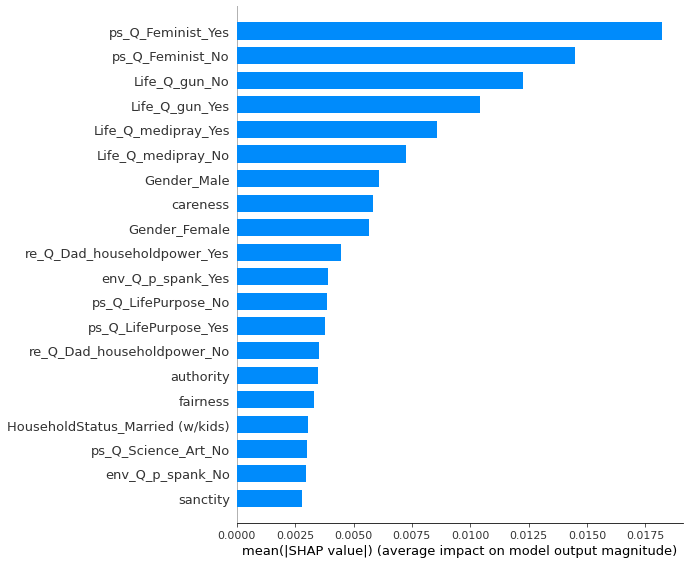

In [92]:
shap.initjs()
shap.summary_plot(shap_values[1],rf_xte_dummy,plot_type = 'bar')

In [93]:
rf_importance = list(sorted(zip(map(lambda x: round(x, 4), rf_rf.feature_importances_), rf_xtr_dummy.columns), 
           reverse=True))
top20 = [nonanswer_importance[i][1] for i in range(len(rf_importance)) if i < 20]
top20

['Gender_Female',
 'sanctity',
 'EducationLevel',
 'careness',
 'HouseholdStatus_Domestic Partners (no kids)',
 'Income',
 'HouseholdStatus_Married (w/kids)',
 'Gender_non_answer',
 'fairness',
 'loyalty',
 'HouseholdStatus_Married (no kids)',
 'authority',
 'HouseholdStatus_non_answer',
 'HouseholdStatus_Single (w/kids)',
 'age_60s',
 'edu_Q_publicschool_No',
 'Gender_Male',
 'edU_Q_mas_doc_degree_non_answer',
 'age_50s',
 'env_Q_Sesame_str_non_answer']

Income, age, edu_Q_publicschool, env_Q_Sesame_str, ex_Q_streee_event, Life_Q_drink, env_Q_p_fight.ifoU 추가



In [94]:
rfe = RFE(estimator=rf_rf, n_features_to_select=20, verbose=1,step = 2)
rfe.fit(rf_xtr_dummy, rf_ytr)

Fitting estimator with 232 features.
Fitting estimator with 230 features.
Fitting estimator with 228 features.
Fitting estimator with 226 features.
Fitting estimator with 224 features.
Fitting estimator with 222 features.
Fitting estimator with 220 features.
Fitting estimator with 218 features.
Fitting estimator with 216 features.
Fitting estimator with 214 features.
Fitting estimator with 212 features.
Fitting estimator with 210 features.
Fitting estimator with 208 features.
Fitting estimator with 206 features.
Fitting estimator with 204 features.
Fitting estimator with 202 features.
Fitting estimator with 200 features.
Fitting estimator with 198 features.
Fitting estimator with 196 features.
Fitting estimator with 194 features.
Fitting estimator with 192 features.
Fitting estimator with 190 features.
Fitting estimator with 188 features.
Fitting estimator with 186 features.
Fitting estimator with 184 features.
Fitting estimator with 182 features.
Fitting estimator with 180 features.
F

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='entropy',
                                     max_depth=9, max_features='log2',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=300, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=20, step=2, verbose=1)

In [95]:
mask = rfe.support_
rfe_tr20 = rf_xtr_dummy.loc[:, mask]
rfe_te20 = rf_xte_dummy.loc[:,mask]
print(rfe_tr30.columns)

Index(['EducationLevel', 'careness', 'fairness', 'loyalty', 'authority',
       'sanctity', 'Gender_Male', 'marriage_Married', 'kids_no kids',
       'Life_Q_drink_Yes', 'env_Q_Sesame_str_Yes', 'ex_Q_stress_event_Yes',
       'edU_Q_mas_doc_degree_No', 'ps_Q_Study_Try_Yes', 'Life_Q_readBook_No',
       'Life_Q_glasses_Yes', 'ex_Q_crimethreatened_No', 'ps_Q_happy_right_No',
       'Life_Q_gun_No', 'Life_Q_gun_Yes', 'ps_Q_ChangedPersonality_Yes',
       'mo_Q_live_metro_Yes', 'Life_Q_medipray_No', 'Life_Q_medipray_Yes',
       'Life_Q_MacPC_No', 'ps_Q_Feminist_No', 'ps_Q_Feminist_Yes',
       'Life_Q_morningAlarm_Yes', 're_Q_Dad_householdpower_Yes',
       'ps_Q_Overweight_Yes'],
      dtype='object')


In [ ]:
['ps_Q_Feminist','Life_Q_gun','Life_Q_medipray','Gender','careness','re_Q_Dad_householdpower','env_Q_p_spank',
 'ps_Q_LifePurpose','authority','fairness','HouseholdStatus','ps_Q_Science_Art','sanctity',
 'EducationLevel','Income','loyalty','age','env_Q_Sesame_str',
 'kids','Life_Q_drink','ex_Q_stress_event','edU_Q_mas_doc_degree','ex_Q_crimethreatened','ps_Q_happy_right',
 'ps_Q_ChangedPersonality','mo_Q_live_metro','Life_Q_MacPC','Life_Q_morningAlarm','ps_Q_Overweight']

ps_Q_Study_Try, env_Q_same_state, ps_Q_happy_right, ps_Q_StartHabit, ps_Q_ChangedPersonality, Life_Q_tabwater, mo_Q_live_metro, Life_Q_driveTunesTalk, edu_Q_allA, re_Q_extendedfamily, Life_Q_ownTool, Life_Q_brush2 추가

In [97]:
selected_xtr = rf_xtr[['ps_Q_Feminist','Life_Q_gun','Life_Q_medipray','Gender','careness','re_Q_Dad_householdpower','env_Q_p_spank',
 'ps_Q_LifePurpose','authority','fairness','HouseholdStatus','ps_Q_Science_Art','sanctity',
 'EducationLevel','Income','loyalty','age','env_Q_Sesame_str',
 'kids','Life_Q_drink','ex_Q_stress_event','edU_Q_mas_doc_degree','ex_Q_crimethreatened','ps_Q_happy_right',
 'ps_Q_ChangedPersonality','mo_Q_live_metro','Life_Q_MacPC','Life_Q_morningAlarm','ps_Q_Overweight']]
selected_xtr_dummy = pd.get_dummies(selected_xtr)

selected_xte = rf_xte[['ps_Q_Feminist','Life_Q_gun','Life_Q_medipray','Gender','careness','re_Q_Dad_householdpower','env_Q_p_spank',
 'ps_Q_LifePurpose','authority','fairness','HouseholdStatus','ps_Q_Science_Art','sanctity',
 'EducationLevel','Income','loyalty','age','env_Q_Sesame_str',
 'kids','Life_Q_drink','ex_Q_stress_event','edU_Q_mas_doc_degree','ex_Q_crimethreatened','ps_Q_happy_right',
 'ps_Q_ChangedPersonality','mo_Q_live_metro','Life_Q_MacPC','Life_Q_morningAlarm','ps_Q_Overweight']]
selected_xte_dummy = pd.get_dummies(selected_xte)

In [99]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
criterion = ['gini','entropy']
max_features = ['log2', 'sqrt']
min_samples_split = [x for x in range(2,20,2)]
min_samples_leaf = [1,2,3,4,5,6,7,8,9,10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'criterion':criterion,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

selected_random = RandomizedSearchCV(estimator = RFC(), param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
selected_random.fit(selected_xtr_dummy, rf_ytr) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [100]:
selected_random.best_params_

{'criterion': 'gini',
 'max_depth': 100,
 'max_features': 'log2',
 'min_samples_leaf': 8,
 'min_samples_split': 6,
 'n_estimators': 200}

In [101]:
param_grid = {
    'n_estimators':[100,200,300],
    'max_depth':[90,100,110],
    'criterion':['gini'],
    'max_features':['log2'],
    'min_samples_split':[4,6,8],
    'min_samples_leaf':[7,8,9]
}

In [102]:
selected_grid = GridSearchCV(estimator = RFC(), param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
selected_grid.fit(selected_xtr_dummy, rf_ytr)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  2.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [103]:
selected_grid.best_params_

{'criterion': 'gini',
 'max_depth': 100,
 'max_features': 'log2',
 'min_samples_leaf': 8,
 'min_samples_split': 4,
 'n_estimators': 100}

In [104]:
# Nonanswer Best params: OrderedDict([('criterion', 'gini'), ('max_depth', 9), ('max_features', 'sqrt'), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 500)])
rf_rf = RFC(
    n_estimators = 100, max_depth = 100, criterion = 'gini', max_features = 'log2',min_samples_leaf = 8,min_samples_split = 4
)
rf_rf.fit(selected_xtr_dummy,rf_ytr)
rf_pred = rf_rf.predict(selected_xte_dummy)

yte['Predictions'] = rf_pred

In [105]:
yte.to_csv("selected_rf.csv")

In [106]:
rf_rf.fit(selected_xtr_dummy,rf_ytr)
rf_pred = rf_rf.predict(selected_xtr_dummy)
print('예측 정확도: {0:.4f}'.format(accuracy_score(rf_ytr,rf_pred)))

예측 정확도: 0.7772


응 아니야......